# Diesel Price Prediction

A cleaned up version of the notebook

Data from https://www.eia.gov/petroleum/gasdiesel/

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import time
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from bayes_opt import BayesianOptimization

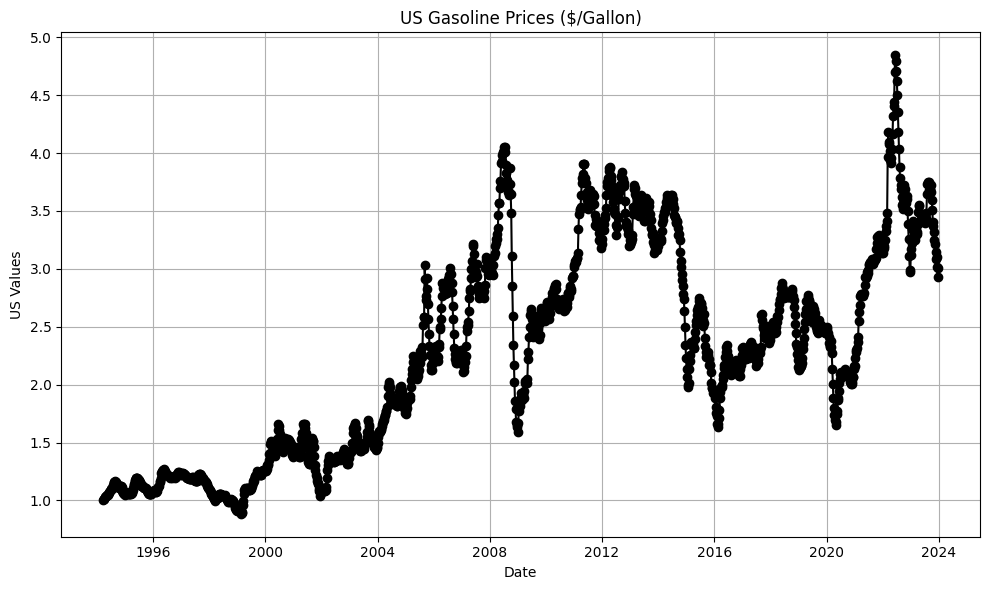

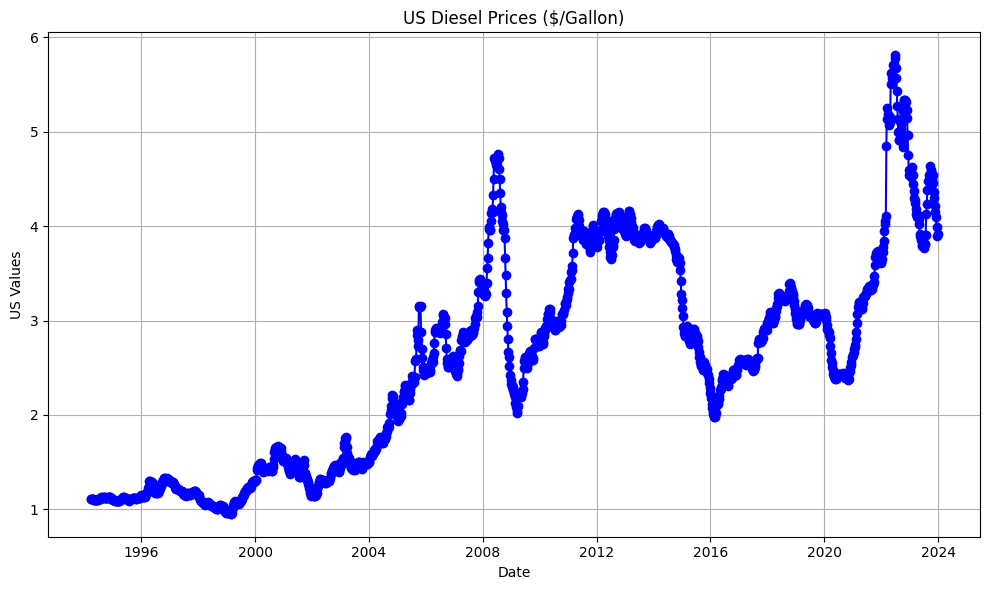

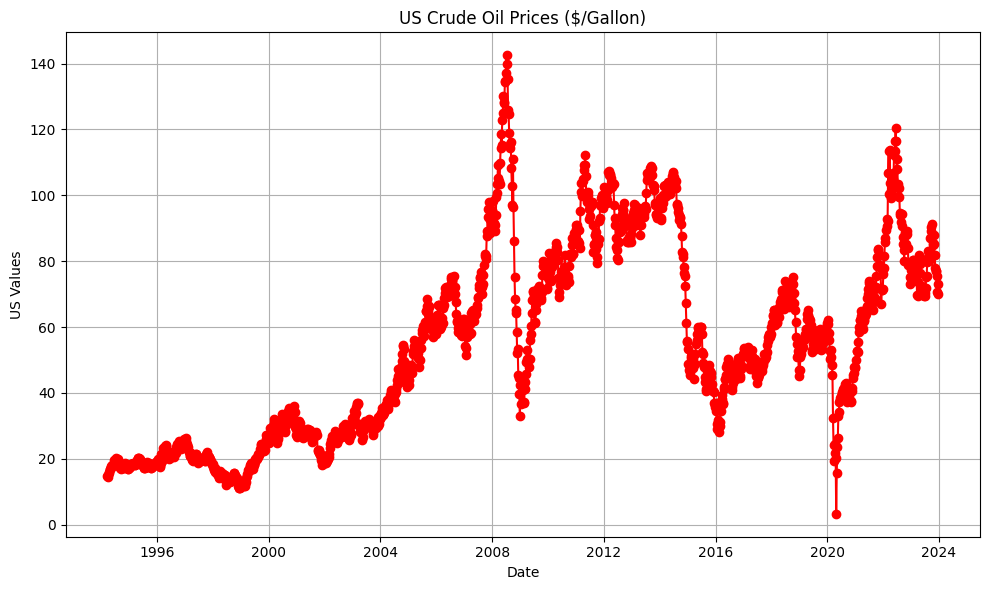

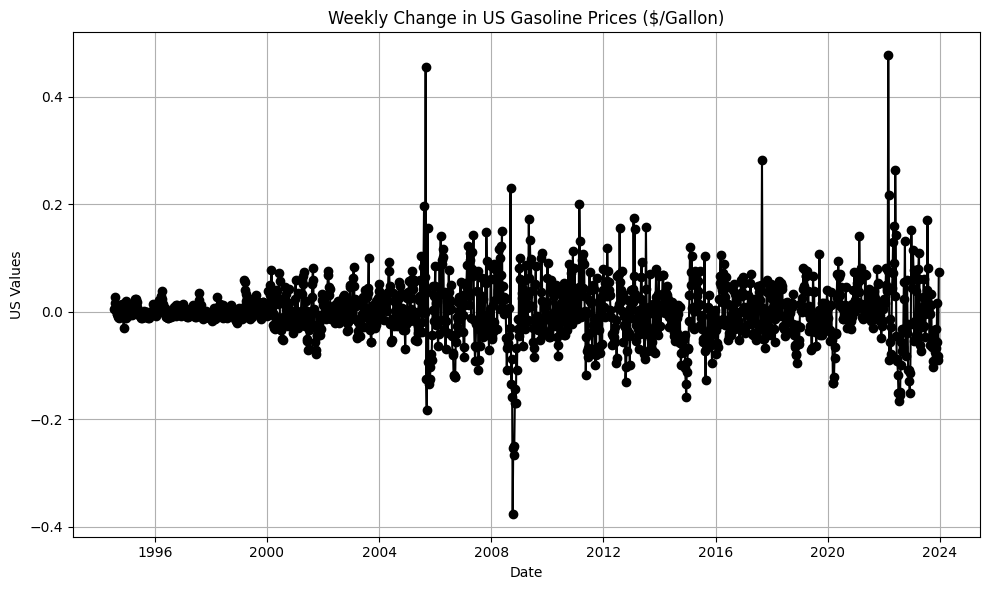

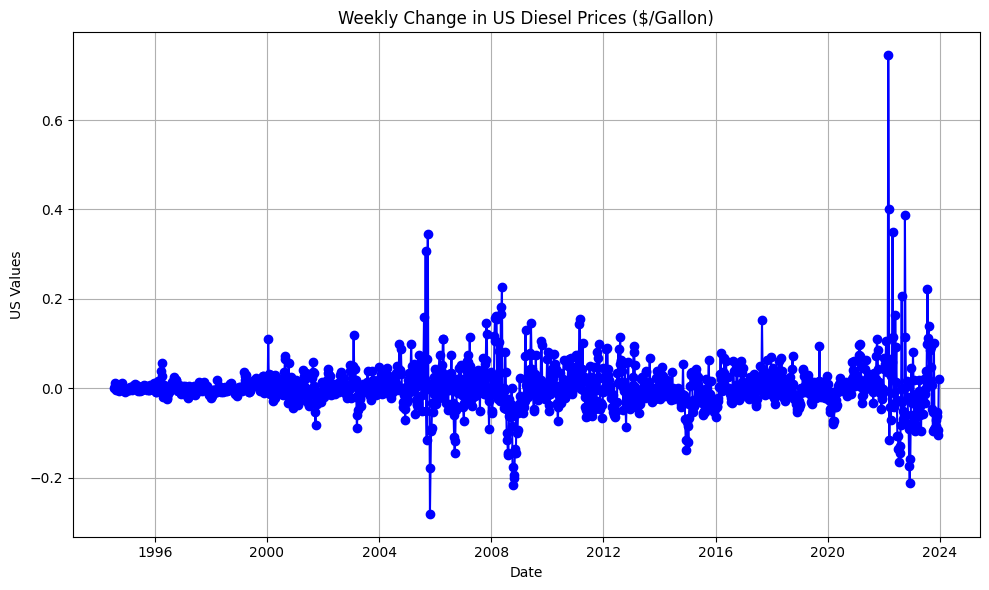

,Gasoline,Diesel,Crude,GasolineDiff1,DieselDiff1,CrudeDiff1,GasolineDiff2,DieselDiff2,CrudeDiff2,GasolineDiff3,...,DieselDiff15,CrudeDiff15,GasolineDiff16,DieselDiff16,CrudeDiff16,GasolineDiff17,DieselDiff17,CrudeDiff17,GasChange,DieselChange
0,1.109,1.111,20.16,0.006,0.001,0.77,0.012,0.002,1.00,0.014,...,0.002,5.72,0.097,0.004,5.01,0.102,0.005,5.34,0.005,-0.000
1,1.114,1.111,19.39,0.005,0.000,-0.77,0.011,0.001,0.00,0.017,...,0.003,3.74,0.103,0.002,4.95,0.102,0.004,4.24,0.016,0.005
2,1.130,1.116,19.66,0.016,0.005,0.27,0.021,0.005,-0.50,0.027,...,0.011,3.59,0.102,0.008,4.01,0.119,0.007,5.22,0.027,0.011
3,1.157,1.127,20.09,0.027,0.011,0.43,0.043,0.016,0.70,0.048,...,0.021,3.07,0.124,0.022,4.02,0.129,0.019,4.44,0.004,-0.000
4,1.161,1.127,18.88,0.004,0.000,-1.21,0.031,0.011,-0.78,0.047,...,0.023,1.95,0.124,0.021,1.86,0.128,0.022,2.81,0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,3.144,4.209,76.98,-0.068,-0.085,-0.94,-0.101,-0.157,-5.01,-0.176,...,-0.030,-4.42,-0.506,0.082,-2.70,-0.335,0.304,1.37,-0.056,-0.063
1532,3.088,4.146,77.02,-0.056,-0.063,0.04,-0.124,-0.148,-0.90,-0.157,...,-0.232,-6.02,-0.643,-0.093,-4.38,-0.562,0.019,-2.66,0.016,-0.054
1533,3.104,4.092,75.49,0.016,-0.054,-1.53,-0.040,-0.117,-1.49,-0.108,...,-0.297,-5.44,-0.642,-0.286,-7.55,-0.627,-0.147,-5.91,-0.090,-0.105
1534,3.014,3.987,70.71,-0.090,-0.105,-4.78,-0.074,-0.159,-6.31,-0.130,...,-0.488,-9.26,-0.732,-0.402,-10.22,-0.732,-0.391,-12.33,-0.083,-0.093


In [27]:
# Crude oil
# Path to the crude prices Excel file
file_path_crude = '../data/raw/PET_PRI_SPT_S1_W.xls'
# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_crude = pd.read_excel(file_path_crude, sheet_name='Data 1', header=2)
# rename columns
df_crude = df_crude.rename(columns={'Weekly Cushing, OK WTI Spot Price FOB  (Dollars per Barrel)': 'Crude'})
# shift Date to align with diesel prices
df_crude['Date'] = df_crude['Date'] + pd.Timedelta(days=3)

# diesel
# Path to the Excel file
file_path_diesel = '../data/raw/psw18vwall.xls'
# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_diesel = pd.read_excel(file_path_diesel, sheet_name='Data 1', header=2)
# rename columns
df_diesel = df_diesel.rename(columns={'Weekly U.S. No 2 Diesel Retail Prices  (Dollars per Gallon)': 'Diesel'})

# gasoline
# path to Excel file
file_path_gas = '../data/raw/pswrgvwall.xls'
# Read the 'Data 1' sheet into a DataFrame, skipping the first two rows
df_gas = pd.read_excel(file_path_gas, sheet_name='Data 1', header=2)
# rename columns
df_gas = df_gas.rename(columns={'Weekly U.S. Regular Conventional Retail Gasoline Prices  (Dollars per Gallon)': 'Gasoline'})

# # inner joins
df = pd.merge(df_gas[['Date','Gasoline']], df_diesel[['Date','Diesel']], on='Date', how='inner')
df = pd.merge(df, df_crude[['Date','Crude']], on='Date', how='inner')

# Plotting gas
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Gasoline'], marker='o', color='black', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Gasoline Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# Plotting diesel
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Diesel'], marker='o', color='blue', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Diesel Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# Plotting Crude oil
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Crude'], marker='o', color='red', linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('US Crude Oil Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# adding in some difference columns
num_differences = 17
for i in range(num_differences):
    crudeCol = 'CrudeDiff' + str(i+1)
    petroCol = 'DieselDiff' + str(i+1)
    gasCol = 'GasolineDiff' + str(i+1)
    df[gasCol] = df['Gasoline'].diff(i+1)
    df[petroCol] = df['Diesel'].diff(i+1)
    df[crudeCol] = df['Crude'].diff(i+1)

# targets to predict
df['GasChange'] = -df['Gasoline'].diff(-1)
df['DieselChange'] = -df['Diesel'].diff(-1)

# dropping rows with now empty information
df = df.drop(df.index[:num_differences])
df = df.drop(df.index[-1])

# reset index
df.reset_index(drop=True, inplace=True)

# Plotting Gasoline differences
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['GasChange'], marker='o', color='black')#, linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('Weekly Change in US Gasoline Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# Plotting Diesel differences
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['DieselChange'], marker='o', color='blue')#, linestyle='-')
plt.xlabel('Date')
plt.ylabel('US Values')
plt.title('Weekly Change in US Diesel Prices ($/Gallon)')
plt.grid(True)  # Add grid lines
plt.tight_layout()
plt.show()

# remove dates as they don't go into XGBoost
df.drop('Date', axis=1, inplace=True)

df

## Diesel Prediction

In [21]:
# setting aside a test set so we don't select hyperparameters on it
# keep it secret, keep it safe
testSize = 104
df_train = df[:-testSize]
X, y = df_train.drop(['GasChange','DieselChange'], axis=1), df_train['DieselChange']

In [22]:
# Objective function for Bayesian optimization
def objective(n_estimators, learning_rate, alpha, reg_lambda, colsample_bytree, max_depth):
    params = {
        'n_estimators': int(n_estimators),
        'learning_rate': learning_rate,
        'alpha': alpha,
        'reg_lambda': reg_lambda,
        'colsample_bytree': colsample_bytree,
        'max_depth': int(max_depth)
    }
    
    xgb = XGBRegressor(**params)
    tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=52, test_size=1)
    
    mse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)
    
    return -np.mean(mse_scores)  # Minimize negative mean squared error

# Define the search space
pbounds = {
    'n_estimators': (500, 1000),
    'learning_rate': (0.01, 0.5),
    'alpha': (0, 5),
    'reg_lambda': (5, 90),
    'colsample_bytree': (0.2,0.9),
    'max_depth': (1,5)
}

# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    # random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=11,  # Number of random exploration points
    n_iter=17,      # Number of iterations for the bayesian optimization
)

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -0.000846 | 2.466     | 0.2165    | 0.2501    | 3.256     | 921.5     | 46.53     |
| 2         | -0.000753 | 1.029     | 0.419     | 0.4118    | 1.39      | 519.6     | 7.75      |
| 3         | -0.001032 | 4.627     | 0.8491    | 0.02426   | 3.133     | 820.7     | 42.98     |
| 4         | -0.000957 | 2.961     | 0.4936    | 0.09544   | 1.699     | 538.9     | 25.85     |
| 5         | -0.000872 | 2.535     | 0.8555    | 0.493     | 4.985     | 751.5     | 43.93     |
| 6         | -0.000940 | 2.905     | 0.4247    | 0.04605   | 2.671     | 956.1     | 60.42     |
| 7         | -0.000917 | 0.01795   | 0.5547    | 0.1055    | 2.867     | 551.0     | 35.38     |
| 8         | -0.000944 | 3.439     | 0.749     | 0.09294   | 4.02      | 875.8     | 28.15     |
| 9         | -0.000

In case I re-run the notebook, the best hyperparameters (diesel prediction, no gas attached, 17 lags) that I have found so far are:

best_params = {'alpha': 0.7339720230399988, 'colsample_bytree': 0.5708620964457474, 'learning_rate': 0.0741255375569539, 'max_depth': 1.9442997734079124, 'n_estimators': 598.0104939690085, 'reg_lambda': 65.23726072241632}

The in-sample target value is -0.000688.

The best hyperparameters (diesel prediction, gas attached, 17 lags) that I have found so far are:

best_params = {'alpha': 0.9451594965588395, 'colsample_bytree': 0.6032657896492717, 'learning_rate': 0.03371559259538288, 'max_depth': 2.654342627535919, 'n_estimators': 517.879878690663, 'reg_lambda': 7.272143336321744}

The in-sample target value is -0.000711.

The best hyperparameters (gas prediction, all attached, 17 lags) that I have found so far are:

best_params = {'alpha': 2.021851869532555, 'colsample_bytree': 0.3356887204578178, 'learning_rate': 0.22354828682458217, 'max_depth': 1.5313928160873287, 'n_estimators': 639.4984109307318, 'reg_lambda': 31.731202615851384}

The in-sample target value is -0.000990.

In [23]:
# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

# measuring on test set
X, y = df.drop(['GasChange','DieselChange'], axis=1), df['DieselChange']

xgb = XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    alpha=best_params['alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    max_depth=int(best_params['max_depth'])
)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=testSize, test_size=1)

xgb_err = []
naive_err = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    xgb_err.append(abs(y_test.values[0] - y_pred[0])**2)
    naive_err.append(y_test.values[0]**2)

print('Diesel XGBoost MSE is:')
print(sum(xgb_err)/testSize)  # Minimize negative mean squared error

print('Diesel Naive MSE is:')
print(sum(naive_err)/testSize)  # Minimize negative mean squared error


{'alpha': 0.9451594965588395, 'colsample_bytree': 0.6032657896492717, 'learning_rate': 0.03371559259538288, 'max_depth': 2.654342627535919, 'n_estimators': 517.879878690663, 'reg_lambda': 7.272143336321744}
Diesel XGBoost MSE is:
0.013280867550637019
Diesel Naive MSE is:
0.016016624999999993


## Gas Prediction



In [24]:
# setting aside a test set so we don't select hyperparameters on it
# keep it secret, keep it safe
testSize = 104
df_train = df[:-testSize]
X, y = df_train.drop(['GasChange','DieselChange'], axis=1), df_train['GasChange']

# Initialize Bayesian optimization
optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    # random_state=42,
)

# Perform optimization
optimizer.maximize(
    init_points=7,  # Number of random exploration points
    n_iter=13,      # Number of iterations for the bayesian optimization
)

# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

|   iter    |  target   |   alpha   | colsam... | learni... | max_depth | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -0.001018 | 1.704     | 0.6404    | 0.2982    | 2.431     | 629.1     | 68.95     |
| 2         | -0.000999 | 1.695     | 0.3101    | 0.3072    | 1.23      | 640.3     | 33.31     |
| 3         | -0.001039 | 2.989     | 0.5512    | 0.459     | 3.208     | 911.0     | 56.41     |
| 4         | -0.001027 | 1.855     | 0.6873    | 0.2824    | 4.205     | 750.1     | 7.875     |
| 5         | -0.000996 | 2.382     | 0.6724    | 0.02117   | 3.726     | 760.9     | 73.5      |
| 6         | -0.001065 | 4.17      | 0.8789    | 0.06698   | 4.139     | 548.7     | 23.24     |
| 7         | -0.001018 | 1.324     | 0.7712    | 0.04415   | 1.761     | 946.7     | 23.34     |
| 8         | -0.001125 | 1.01      | 0.5468    | 0.35      | 3.028     | 739.4     | 85.73     |
| 9         | -0.000

In [25]:
# Access the best hyperparameters found
best_params = optimizer.max['params']
print(best_params)

# measuring on test set
X, y = df.drop(['GasChange','DieselChange'], axis=1), df['GasChange']

xgb = XGBRegressor(
    objective ='reg:squarederror',
    n_estimators=int(best_params['n_estimators']),
    learning_rate=best_params['learning_rate'],
    alpha=best_params['alpha'],
    reg_lambda=best_params['reg_lambda'],
    colsample_bytree=best_params['colsample_bytree'],
    max_depth=int(best_params['max_depth'])
)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=testSize, test_size=1)

xgb_err = []
naive_err = []
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    xgb_err.append(abs(y_test.values[0] - y_pred[0])**2)
    naive_err.append(y_test.values[0]**2)

print('Gas XGBoost MSE is:')
print(sum(xgb_err)/testSize)  # Minimize negative mean squared error

print('Gas Naive MSE is:')
print(sum(naive_err)/testSize)  # Minimize negative mean squared error


{'alpha': 2.021851869532555, 'colsample_bytree': 0.3356887204578178, 'learning_rate': 0.22354828682458217, 'max_depth': 1.5313928160873287, 'n_estimators': 639.4984109307318, 'reg_lambda': 31.731202615851384}
Gas XGBoost MSE is:
0.006545022015725013
Gas Naive MSE is:
0.008992374999999999


## predicting next week

In [30]:
df_train = pd.read_csv('../data/interim/lagged_data.csv')
df_test = pd.read_csv('../data/interim/latest_week.csv')

def get_trained_xgboost(df_train, target_column, best_params):
    # target and features
    X = df_train.drop(columns = ['GasChange','DieselChange'])
    y = df_train[target_column]

    # Create an XGBoost regressor model
    xgb = XGBRegressor(
        objective ='reg:squarederror',
        n_estimators=int(best_params['n_estimators']),
        learning_rate=best_params['learning_rate'],
        alpha=best_params['alpha'],
        reg_lambda=best_params['reg_lambda'],
        colsample_bytree=best_params['colsample_bytree'],
        max_depth=int(best_params['max_depth'])
    )

    # train and return model
    xgb.fit(X,y)
    return xgb

params_gas = {'alpha': 2.021851869532555, 'colsample_bytree': 0.3356887204578178, 'learning_rate': 0.22354828682458217, 'max_depth': 1.5313928160873287, 'n_estimators': 639.4984109307318, 'reg_lambda': 31.731202615851384}

xgb = get_trained_xgboost(df_train, 'GasChange', params_gas)



In [32]:
xgb.predict(df_test)[0]

0.01565683

In [36]:
df

,Gasoline,Diesel,Crude,GasolineDiff1,DieselDiff1,CrudeDiff1,GasolineDiff2,DieselDiff2,CrudeDiff2,GasolineDiff3,...,DieselDiff15,CrudeDiff15,GasolineDiff16,DieselDiff16,CrudeDiff16,GasolineDiff17,DieselDiff17,CrudeDiff17,GasChange,DieselChange
0,1.109,1.111,20.16,0.006,0.001,0.77,0.012,0.002,1.00,0.014,...,0.002,5.72,0.097,0.004,5.01,0.102,0.005,5.34,0.005,-0.000
1,1.114,1.111,19.39,0.005,0.000,-0.77,0.011,0.001,0.00,0.017,...,0.003,3.74,0.103,0.002,4.95,0.102,0.004,4.24,0.016,0.005
2,1.130,1.116,19.66,0.016,0.005,0.27,0.021,0.005,-0.50,0.027,...,0.011,3.59,0.102,0.008,4.01,0.119,0.007,5.22,0.027,0.011
3,1.157,1.127,20.09,0.027,0.011,0.43,0.043,0.016,0.70,0.048,...,0.021,3.07,0.124,0.022,4.02,0.129,0.019,4.44,0.004,-0.000
4,1.161,1.127,18.88,0.004,0.000,-1.21,0.031,0.011,-0.78,0.047,...,0.023,1.95,0.124,0.021,1.86,0.128,0.022,2.81,0.004,-0.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,3.144,4.209,76.98,-0.068,-0.085,-0.94,-0.101,-0.157,-5.01,-0.176,...,-0.030,-4.42,-0.506,0.082,-2.70,-0.335,0.304,1.37,-0.056,-0.063
1532,3.088,4.146,77.02,-0.056,-0.063,0.04,-0.124,-0.148,-0.90,-0.157,...,-0.232,-6.02,-0.643,-0.093,-4.38,-0.562,0.019,-2.66,0.016,-0.054
1533,3.104,4.092,75.49,0.016,-0.054,-1.53,-0.040,-0.117,-1.49,-0.108,...,-0.297,-5.44,-0.642,-0.286,-7.55,-0.627,-0.147,-5.91,-0.090,-0.105
1534,3.014,3.987,70.71,-0.090,-0.105,-4.78,-0.074,-0.159,-6.31,-0.130,...,-0.488,-9.26,-0.732,-0.402,-10.22,-0.732,-0.391,-12.33,-0.083,-0.093
